<h3>Importing Libraries

In [107]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('default')
from datetime import datetime, timedelta 
import pytz
from pytz import timezone
import plotly.graph_objects as go
import datetime as dt
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
warnings.filterwarnings("ignore")

## Installing packages


In [108]:
#1. yfinance - !pip install yfinance
#2. mathplot - !pip install matplotlib
#3. pytz - !pip install pytz
#4. pandas - !pip install pandas
#5. numpy - !pip install numpy
#6. plotly - !pip install plotly
#7. pmdarima - !pip install pmdarima
#8. statmodels - !pip install stat
#9. plotly express - !pip install plotly-express
#10. pmdarima - !pip install pmdarima

List of Abbreviations<br>
• ETL = Extract Transform Load<br>
• EDA = Exploratory Data Analysis<br>
• ARIMA = Auto Regressive Integrated Moving Average<br>
• P/E ratio= share price to earnings per share ratio<br>
• KPI = Key Performance Indicators<br>
• EBITDA Margin = Earnings Before Interest, Taxes, Depreciation, and Amortization Margin<br>
• EPS = Earnings per share<br>
• SMA = Simple Moving Average<br>
• EMA = Exponential Moving Average<br>
• RSI = Relative Strength Index<br>
• MACD = Moving Average Convergence Divergence<br>
• ATR = Average True Range<br>

<h3>Input Values
<h4> Enter the Company stock Symbol and enter the number of Years.

In [109]:
a = str(input("Enter the company stock symbol value: ")).upper()
b = int(input("Enter the number of years to get the data: "))
c = yf.Ticker(a)

Enter the company stock symbol value:  VOW3.DE
Enter the number of years to get the data:  2


## Extraction

<h3>Extraction Related to Financial Indicators

<h5>Income Statement

In [110]:
Income_Statements_df = c.financials
Income_Statements_df.head() 
#Income_Statements_df.stack()

,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,702744000.0,519823000.0,495808000.0
Tax Rate For Calcs,0.282,0.233,0.244
Normalized EBITDA,49682000000.0,47202000000.0,38519000000.0
Total Unusual Items,2492000000.0,2231000000.0,2032000000.0
Total Unusual Items Excluding Goodwill,2492000000.0,2231000000.0,2032000000.0


In [111]:
Income_Statements_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Tax Effect Of Unusual Items to Operating Revenue
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   2022-12-31 00:00:00  47 non-null     object
 1   2021-12-31 00:00:00  47 non-null     object
 2   2020-12-31 00:00:00  48 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


<h5>Cash Flow

In [112]:
Cash_Flow_df= c.cashflow
Cash_Flow_df.head()

,2022-12-31,2021-12-31,2020-12-31
Free Cash Flow,5825000000.0,20135000000.0,7155000000.0
Repayment Of Debt,-25638000000.0,-30557000000.0,-19815000000.0
Issuance Of Debt,23876000000.0,32659000000.0,25181000000.0
Capital Expenditure,-22671000000.0,-18498000000.0,-17746000000.0
End Cash Position,29738000000.0,39123000000.0,33432000000.0


In [113]:
Cash_Flow_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, Free Cash Flow to Net Income From Continuing Operations
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   2022-12-31 00:00:00  40 non-null     object
 1   2021-12-31 00:00:00  42 non-null     object
 2   2020-12-31 00:00:00  43 non-null     object
dtypes: object(3)
memory usage: 1.4+ KB


<h5>Balance Sheet

In [114]:
Balance_Sheet_df = c.balance_sheet
Balance_Sheet_df.head()

,2022-12-31,2021-12-31,2020-12-31
Ordinary Shares Number,501295263.0,501295263.0,501295263.0
Share Issued,501295263.0,501295263.0,501295263.0
Net Debt,142879000000.0,137401000000.0,134278000000.0
Total Debt,178436000000.0,183370000000.0,174312000000.0
Tangible Book Value,82137000000.0,66760000000.0,59081000000.0


In [115]:
Balance_Sheet_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, Ordinary Shares Number to Cash Financial
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   2022-12-31 00:00:00  78 non-null     object
 1   2021-12-31 00:00:00  80 non-null     object
 2   2020-12-31 00:00:00  81 non-null     object
dtypes: object(3)
memory usage: 2.5+ KB


Date Extraction for P/E ratio

In [116]:
dates =Income_Statements_df.columns.tolist() # for P/E ratio
dates
dates_only = [timestamp.date() for timestamp in dates]
dates_only
formatted_dates = [date.strftime('%Y-%m-%d') for date in dates_only]
formatted_dates 
 

['2022-12-31', '2021-12-31', '2020-12-31']

Stock Prices for extracted dates

In [117]:
historical_data = c.history(period='5y', interval='1d')
date_objects = pd.to_datetime(formatted_dates)
selected_data = pd.DataFrame()

# Loop through each date and get data from the last available trading day if not found
for date in date_objects:
    date_str = date.strftime('%Y-%m-%d')
    try:
        # Convert date to the timezone of the DataFrame's index
        date = date.tz_localize(timezone('UTC')).tz_convert(historical_data.index.tzinfo)
        date_data = historical_data.loc[[date]]
    except KeyError:
        print(f"Data not available for {date_str}. Getting data from the last available trading day.")

        # Get data from the last available trading day
        last_trading_day = historical_data.index[historical_data.index <= date].max()

        # Handle NaT (Not a Time) value
        if pd.isna(last_trading_day):
            print("No previous trading day available.")
            continue

        date_data = historical_data.loc[[last_trading_day.strftime('%Y-%m-%d')]]

    
    selected_data = pd.concat([selected_data, date_data])

selected_data


Data not available for 2022-12-31. Getting data from the last available trading day.
Data not available for 2021-12-31. Getting data from the last available trading day.
Data not available for 2020-12-31. Getting data from the last available trading day.


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-30 00:00:00+01:00,108.015764,108.481188,107.475869,108.369484,365926,0.0,0.0
2021-12-30 00:00:00+01:00,134.442557,134.807144,134.062776,134.807144,333679,0.0,0.0
2020-12-30 00:00:00+01:00,112.484273,113.077782,111.267586,113.077782,578887,0.0,0.0


In [118]:
selected_data.drop(['High', 'Low', 'Open', 'Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)

In [119]:
selected_data.rename(columns={'Close': 'Stock Price'}, inplace=True) #renaming the column stock price
selected_data.index.name = ""
selected_data.index = selected_data.index.year#to display only year in the index 

In [120]:
selected_data['Stock Price']


2022    108.369484
2021    134.807144
2020    113.077782
Name: Stock Price, dtype: float64

<h3>Extraction Related to Technical Indicators

In [121]:
# Specific date  
 #end_date = "2023-11-09"
# Automatic Date updation as per todays date
end_date = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*b)
# Specifing the timezone
#timezone = 'Europe/Berlin'
data_df = yf.download(tickers = a, 
                      start = start_date, 
                      end = end_date)
                      #tz=timezone)
#data_df.info()
data_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-01,176.720001,178.679993,164.100006,164.479996,124.932808,2668369
2022-03-02,162.000000,166.199997,156.559998,160.000000,121.529976,2665692
2022-03-03,159.039993,161.220001,154.559998,155.360001,118.005608,2126189
2022-03-04,151.000000,152.220001,143.160004,144.500000,109.756767,3043218
2022-03-07,139.000000,142.979996,133.139999,136.740005,103.862564,3024752
...,...,...,...,...,...,...
2024-02-22,120.500000,123.519997,119.820000,122.400002,122.400002,1749921
2024-02-23,122.300003,124.019997,122.300003,124.000000,124.000000,1230615
2024-02-26,123.760002,123.900002,122.360001,123.019997,123.019997,521656


<h3>Extraction Related to Machine Learning Model

note: Data Extracted from Technical Indicators And Machine Learning Model is Same. 
but for understanding purposes the step is repeated.

In [122]:
end_date = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*b)
Timeseries_df = yf.download(tickers = a, 
                      start = start_date, 
                      end = end_date)
        
Timeseries_df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-22,120.500000,123.519997,119.820000,122.400002,122.400002,1749921
2024-02-23,122.300003,124.019997,122.300003,124.000000,124.000000,1230615
2024-02-26,123.760002,123.900002,122.360001,123.019997,123.019997,521656
2024-02-27,122.879997,124.459999,122.360001,124.080002,124.080002,680794
2024-02-28,123.860001,125.879997,123.599998,125.879997,125.879997,1030279


## Transformation

<h3>Transformation Related to Financial Indicators

Combining All Data Frames

In [123]:
# Joining Income Statements and Cash flow
Combined_df = pd.concat([Income_Statements_df, Cash_Flow_df])

# Joining the resulting DataFrame with Balance Sheets
Combined_Annual_Report_df = pd.concat([Combined_df, Balance_Sheet_df])
Combined_Annual_Report_df

,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,702744000.0,519823000.0,495808000.0
Tax Rate For Calcs,0.282,0.233,0.244
Normalized EBITDA,49682000000.0,47202000000.0,38519000000.0
Total Unusual Items,2492000000.0,2231000000.0,2032000000.0
Total Unusual Items Excluding Goodwill,2492000000.0,2231000000.0,2032000000.0
...,...,...,...
Accounts Receivable,60249000000.0,52750000000.0,55744000000.0
Cash Cash Equivalents And Short Term Investments,70786000000.0,66879000000.0,59269000000.0
Other Short Term Investments,41614000000.0,27155000000.0,25359000000.0
Cash And Cash Equivalents,29172000000.0,39724000000.0,33910000000.0


In [124]:
Combined_Annual_Report_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, Tax Effect Of Unusual Items to Cash Financial
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   2022-12-31 00:00:00  165 non-null    object
 1   2021-12-31 00:00:00  169 non-null    object
 2   2020-12-31 00:00:00  172 non-null    object
dtypes: object(3)
memory usage: 5.4+ KB


Removing NaN values


In [125]:
# Replace NaN values with 0
updated_df= Combined_Annual_Report_df.fillna(0)
updated_df.head()

,2022-12-31,2021-12-31,2020-12-31
Tax Effect Of Unusual Items,7.027440e+08,5.198230e+08,4.958080e+08
Tax Rate For Calcs,2.820000e-01,2.330000e-01,2.440000e-01
Normalized EBITDA,4.968200e+10,4.720200e+10,3.851900e+10
Total Unusual Items,2.492000e+09,2.231000e+09,2.032000e+09
Total Unusual Items Excluding Goodwill,2.492000e+09,2.231000e+09,2.032000e+09


In [126]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, Tax Effect Of Unusual Items to Cash Financial
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   2022-12-31 00:00:00  173 non-null    float64
 1   2021-12-31 00:00:00  173 non-null    float64
 2   2020-12-31 00:00:00  173 non-null    float64
dtypes: float64(3)
memory usage: 5.4+ KB


In [127]:
# Dropping Timestamp in column name to show only year
updated_df.columns = pd.to_datetime(updated_df.columns).year
updated_df

,2022,2021,2020
Tax Effect Of Unusual Items,7.027440e+08,5.198230e+08,4.958080e+08
Tax Rate For Calcs,2.820000e-01,2.330000e-01,2.440000e-01
Normalized EBITDA,4.968200e+10,4.720200e+10,3.851900e+10
Total Unusual Items,2.492000e+09,2.231000e+09,2.032000e+09
Total Unusual Items Excluding Goodwill,2.492000e+09,2.231000e+09,2.032000e+09
...,...,...,...
Accounts Receivable,6.024900e+10,5.275000e+10,5.574400e+10
Cash Cash Equivalents And Short Term Investments,7.078600e+10,6.687900e+10,5.926900e+10
Other Short Term Investments,4.161400e+10,2.715500e+10,2.535900e+10
Cash And Cash Equivalents,2.917200e+10,3.972400e+10,3.391000e+10


In [128]:
print(updated_df.index)

Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA', 'Total Unusual Items',
       'Total Unusual Items Excluding Goodwill',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT',
       ...
       'Finished Goods', 'Work In Process', 'Raw Materials',
       'Other Receivables', 'Taxes Receivable', 'Accounts Receivable',
       'Cash Cash Equivalents And Short Term Investments',
       'Other Short Term Investments', 'Cash And Cash Equivalents',
       'Cash Financial'],
      dtype='object', length=173)


<h5>Dependencies for the Financial Indicators

In [129]:
import pandas as pd

# Assuming you have a DataFrame called updated_df
# updated_df = ...

# Dependencies are stored in the data value
data = [
    "Gross Profit",
    "Total Revenue",
    "Operating Income",
    "Net Income",
    "EBITDA",
    "Net Income Common Stockholders",
    "Diluted Average Shares",
    "Current Assets",
    "Current Liabilities",
    "Total Debt",
    "Total Equity Gross Minority Interest",
    "Common Stock Equity",
    "Goodwill",
    "Other Intangible Assets",
    "Stockholders Equity",
    "Operating Cash Flow",
    "Capital Expenditure",
    "Cash And Cash Equivalents",
    "Cash Flow From Continuing Operating Activities",
    "Cash Flow From Continuing Investing Activities",
    "Cash Flow From Continuing Financing Activities",
    "EBIT",
    "Net Interest Income",
    "Diluted EPS",
    "Net PPE",
    "Accounts Receivable"
]

# Initialize an empty DataFrame to store cleaned data
Cleaned_data = pd.DataFrame(index=data, columns=updated_df.columns)

# Extract data from updated_df based on keys in data
for key in data:
    if key in updated_df.index:
        value = updated_df.loc[key].values.reshape(1, -1)
        Cleaned_data.loc[key] = value
    else:
        Cleaned_data.loc[key] = 0

Cleaned_data

,2022,2021,2020
Gross Profit,52227000000.0,47240000000.0,38948000000.0
Total Revenue,279232000000.0,250199000000.0,222885000000.0
Operating Income,18220000000.0,15952000000.0,10058000000.0
Net Income,15443000000.0,15382000000.0,8867000000.0
EBITDA,52174000000.0,49433000000.0,40551000000.0
Net Income Common Stockholders,14867000000.0,14843000000.0,8334000000.0
Diluted Average Shares,501295263.0,501295263.0,501295263.0
Current Assets,224309000000.0,200347000000.0,194944000000.0
Current Liabilities,182992000000.0,164393000000.0,165410000000.0
Total Debt,178436000000.0,183370000000.0,174312000000.0


In [130]:
Cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, Gross Profit to Accounts Receivable
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2022    26 non-null     object
 1   2021    26 non-null     object
 2   2020    26 non-null     object
dtypes: object(3)
memory usage: 1.9+ KB


In [131]:
print(Cleaned_data.index)

Index(['Gross Profit', 'Total Revenue', 'Operating Income', 'Net Income',
       'EBITDA', 'Net Income Common Stockholders', 'Diluted Average Shares',
       'Current Assets', 'Current Liabilities', 'Total Debt',
       'Total Equity Gross Minority Interest', 'Common Stock Equity',
       'Goodwill', 'Other Intangible Assets', 'Stockholders Equity',
       'Operating Cash Flow', 'Capital Expenditure',
       'Cash And Cash Equivalents',
       'Cash Flow From Continuing Operating Activities',
       'Cash Flow From Continuing Investing Activities',
       'Cash Flow From Continuing Financing Activities', 'EBIT',
       'Net Interest Income', 'Diluted EPS', 'Net PPE', 'Accounts Receivable'],
      dtype='object')


In [132]:
print(Cleaned_data.columns)

Index([2022, 2021, 2020], dtype='int32')


<h4>Financial Indicators Calculations

In [133]:
def calculate_metrics_for_each_year(df):
    years = df.columns
    
    # Create a new DataFrame to store the calculated metrics
    financial_metrics = pd.DataFrame(index=[
        "Gross Profit Margin", "Operating Profit Margin", "Net Profit Margin",
        "EBIT Margin", "EBITDA Margin", "EPS", "Current Ratio",
        "Debt-to-Equity Ratio", "Tangible Book Value", "Total Debt to Capitalization",
        "Free Cash Flow", "Cash Ratio", "Operational Cash Flow Margin",
        "Investing Cash Flow to Operating Cash Flow Ratio",
        "Financial Cash Flow to Operational Cash Flow Ratio",
        "Operational Cash Flow to Current Liabilities Ratio", "Interest Coverage Ratio",
        "Fixed Asset Turnover", "Debtor Days"
    ], columns=years)
    
    for year in years:
        # Calculate each metric for the given year and update the financial_metrics
        calculate_metrics(df, financial_metrics, year)

    return financial_metrics

def calculate_metrics(df, result_df, year):
    try:
        # Gross Profit Margin
        result_df.at["Gross Profit Margin", year] = (df.at["Gross Profit", year] / df.at["Total Revenue", year]) * 100
        
        # Operating Profit Margin
        result_df.at["Operating Profit Margin", year] = (df.at["Operating Income", year] / df.at["Total Revenue", year]) * 100
        
        # Net Profit Margin
        result_df.at["Net Profit Margin", year] = (df.at["Net Income", year] / df.at["Total Revenue", year]) * 100
    
        # EBIT Margin
        result_df.at["EBIT Margin", year] = (df.at["EBIT", year] / df.at["Total Revenue", year]) * 100
        
        # EBITDA Margin
        result_df.at["EBITDA Margin", year] = (df.at["EBITDA", year] / df.at["Total Revenue", year]) * 100
        
        # EPS
        result_df.at["EPS", year] = df.at["Net Income Common Stockholders", year] / df.at["Diluted Average Shares", year]
        
        # Current Ratio
        result_df.at["Current Ratio", year] = df.at["Current Assets", year] / df.at["Current Liabilities", year]
        
        # Debt-to-Equity Ratio
        result_df.at["Debt-to-Equity Ratio", year] = df.at["Total Debt", year] / df.at["Total Equity Gross Minority Interest", year]
        
        # Tangible Book Value
        result_df.at["Tangible Book Value", year] = df.at["Common Stock Equity", year] - df.at["Goodwill", year] - df.at["Other Intangible Assets", year]
        
        # Total Debt to Capitalization
        result_df.at["Total Debt to Capitalization", year] = df.at["Total Debt", year] / (df.at["Total Debt", year] + df.at["Stockholders Equity", year])
        
        # Free Cash Flow
        result_df.at["Free Cash Flow", year] = df.at["Operating Cash Flow", year] - df.at["Capital Expenditure", year]
        
        # Cash Ratio
        result_df.at["Cash Ratio", year] = df.at["Cash And Cash Equivalents", year] / df.at["Current Liabilities", year]
        
        # Operational Cash Flow Margin
        result_df.at["Operational Cash Flow Margin", year] = (df.at["Cash Flow From Continuing Operating Activities", year] / df.at["Total Revenue", year]) * 100
            
        # Investing Cash Flow to Operating Cash Flow Ratio
        result_df.at["Investing Cash Flow to Operating Cash Flow Ratio", year] = df.at["Cash Flow From Continuing Investing Activities", year] / df.at["Cash Flow From Continuing Operating Activities", year]
        
        # Financial Cash Flow to Operational Cash Flow Ratio
        result_df.at["Financial Cash Flow to Operational Cash Flow Ratio", year] = df.at["Cash Flow From Continuing Financing Activities", year] / df.at["Cash Flow From Continuing Operating Activities", year]
        
        # Operational Cash Flow to Current Liabilities
        result_df.at["Operational Cash Flow to Current Liabilities Ratio", year] = df.at["Cash Flow From Continuing Operating Activities", year] / df.at["Current Liabilities", year]
        
        # Interest Coverage Ratio
        result_df.at["Interest Coverage Ratio", year] = df.at["EBIT", year] / df.at["Net Interest Income", year]
              
        # Fixed Asset Turnover
        result_df.at["Fixed Asset Turnover", year] = df.at["Total Revenue", year] / df.at["Net PPE", year]
        
        # Debtor Days
        result_df.at["Debtor Days", year] = (df.at["Accounts Receivable", year] / df.at["Total Revenue", year]) * 365

    except ZeroDivisionError as e:
        error_message_parts = str(e).split('unsupported operand type(s) for /: ')
        if len(error_message_parts) > 1:
            error_metric = error_message_parts[1].split(' ')[0]
            result_df.at[error_metric, year] = 0
        else:
            print("Unable to extract error metric. Error message:", str(e))

# Example usage
financial_metrics = calculate_metrics_for_each_year(Cleaned_data)  
financial_metrics

Unable to extract error metric. Error message: division by zero
Unable to extract error metric. Error message: division by zero
Unable to extract error metric. Error message: division by zero


,2022,2021,2020
Gross Profit Margin,18.703802,18.880971,17.474482
Operating Profit Margin,6.52504,6.375725,4.512641
Net Profit Margin,5.530527,6.147906,3.978285
EBIT Margin,8.483627,8.83177,6.252103
EBITDA Margin,18.684821,19.757473,18.193687
EPS,29.657172,29.609296,16.624933
Current Ratio,1.225786,1.218708,1.17855
Debt-to-Equity Ratio,1.000606,1.254636,1.353533
Tangible Book Value,82137000000.0,66760000000.0,59081000000.0
Total Debt to Capitalization,0.51899,0.559364,0.578416


<h5>P/E ratio

In [134]:
# Converting 'EPS' series to numeric
Eps_value = pd.to_numeric(financial_metrics.loc['EPS'], errors='coerce')


P_by_ERatio = selected_data['Stock Price'] / Eps_value

# Print the updated financial_data DataFrame
try:
    P_by_ERatio.drop('EPS', inplace=True)
except KeyError:
    print("Exception occured")
P_by_ERatio

Exception occured



2022    3.654073
2021    4.552866
2020    6.801699
dtype: float64

In [135]:
financial_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, Gross Profit Margin to Debtor Days
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2022    13 non-null     object
 1   2021    13 non-null     object
 2   2020    13 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


<h3>Transformation Related to Techinical Indicators

<h4>Technical Indicators Calculations

In [136]:
data_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-01,176.720001,178.679993,164.100006,164.479996,124.932808,2668369
2022-03-02,162.000000,166.199997,156.559998,160.000000,121.529976,2665692
2022-03-03,159.039993,161.220001,154.559998,155.360001,118.005608,2126189
2022-03-04,151.000000,152.220001,143.160004,144.500000,109.756767,3043218
2022-03-07,139.000000,142.979996,133.139999,136.740005,103.862564,3024752


<h4>Simple Moving Average

In [137]:
# Specify the window size for the SMA 365 days 250 working days~68.49%  approx 4.79 days per week so we considered 5 days as simple moving avaerage mean 
window_size = 5 # You can change this to your desired window size
data_df['SMA'] = data_df['Close'].rolling(window=window_size).mean()

<h4> Exponential Moving Average

In [138]:
# alpha value should be between 0&1
##Smaller alpha (e.g., 0.1): Reacts more quickly to recent changes in the data. It id suitable for short-term trends.
##Larger alpha (e.g., 0.5 to 0.2): Smoothes out fluctuations in the data, providing a more stable trend. This will be useful for longer-term trends.

# Defining the smoothing parameter
alpha = 2 / (1 + 10)  # Adjust for the desired level of smoothing 
data_df['EMA'] = data_df['Close'].ewm(alpha=alpha, adjust=False).mean()

<h4>RSI

In [139]:
# Based on the trading strategy the rsi_period can be adjusted
#Usually 7-10 days is used for short term investors, 20-30 days is used for long term investors to smoothen the fluctuations.
#It is used to identify the strength of  momentum & trend,whether the stock is overbought & oversold.
## if RSI > 70 it indicates the stock has been overbought
## if RSI < 30 it indicates the stock has been oversold
### trend & momentum
# if RSI > 50 consistently it indicates bullish momentum
#if RSI < 50 consistently it indicates bearish momentum
rsi_period= 10
delta = data_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
rs = avg_gain / avg_loss
data_df['RSI'] = 100 - (100 / (1 + rs))

<h4> MACD & Signal line

In [140]:
# MACD is the difference between the 12-period EMA and the 26-period EMA. it is used to identify the momentum of a stock.

#Signal Line: This is a 9-period EMA of the MACD. It is used as a trigger for buy and sell signals. 
##When the MACD crosses above the signal line, it may be a bullish signal, suggesting that it might be a good time to buy.
##similarly, when the MACD crosses below the signal line, it may be a bearish signal, indicating that it might be a good time to sell.

# Define the short-term and long-term window sizes in days
short_window = 12
long_window = 26
signal_window = 9

# Calculate the short-term and long-term EMAs
short_ema = data_df['Close'].ewm(span=short_window, adjust=False).mean()
long_ema = data_df['Close'].ewm(span=long_window, adjust=False).mean()

# Calculate the MACD line
data_df['MACD'] = short_ema - long_ema

# Calculate the Signal line
data_df['signal_line'] = data_df['MACD'].ewm(span=signal_window, adjust=False).mean()

<h4>Bollinger bands

In [141]:
# It is mainly used for the volatility Analysis. 
# for short term trading N ranges from 10-20 days. for long term trading N rangers from 50-200 days
# the range of K is between 1.5-2. higher k value is less sensitive to price fluctuation. 
##long term investors use higher k value & short term investors use lower k value. 
N = 20  # Number of days for moving average
K = 2   # Number of standard deviations for Bollinger Bands

data_df['Bollinger_Upper_Band'] = data_df['SMA'] + (K * data_df['Close'].rolling(window=N).std())
data_df['Bollinger_Lower_Band'] = data_df['SMA'] - (K * data_df['Close'].rolling(window=N).std())

<h4> Stochastic Oscillator

In [142]:
#The Stochastic Oscillator is a momentum indicator used to gauge the current price's relative position within its previous high-low range. It aids in identifying overbought or oversold conditions and potential reversals in the prevailing trend.
#Short term Trading 5-14 days, Medium term Trading 14-21 days, & Long term Trading 50-200 days  
Stochastic_Oscillator_window = 5 #Number of days for moving average

highest_high = data_df['High'].rolling(window=Stochastic_Oscillator_window).max()
lowest_low = data_df['Low'].rolling(window=Stochastic_Oscillator_window).min()
data_df['Stochastic_Oscillator_data_df'] = np.where((highest_high - lowest_low) != 0,
                                                (data_df['Close'] - lowest_low) / (highest_high - lowest_low),
                                                0)

<h4>Average True Range

In [143]:
ATR_window = 14 #detremine the period with respect to the trading strategy
def calculate_atr(atr_df, window=ATR_window):
    # Calculate True Range
    atr_df['High-Low'] = atr_df['High'] - atr_df['Low']
    atr_df['High-PrevClose'] = abs(atr_df['High'] - atr_df['Close'].shift(1))
    atr_df['Low-PrevClose'] = abs(atr_df['Low'] - atr_df['Close'].shift(1))

    # Use np.maximum.reduce to find the maximum value across columns
    atr_df['True_Range'] = np.maximum.reduce([
        atr_df['High-Low'],
        atr_df['High-PrevClose'],
        atr_df['Low-PrevClose']
    ])
    
    # Calculate ATR using the rolling mean of True Range
    atr_df['Average_True_Range'] = atr_df['True_Range'].rolling(window=window).mean()

    # Drop intermediate columns
    atr_df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'True_Range'], axis=1, inplace=True)

    return atr_df
    
Average_True_Range_df = calculate_atr(data_df, window=ATR_window)
#print(Average_True_Range_df)

<h4>Ichimoku Cloud

In [144]:
import pandas as pd

def ichimoku_cloud(df, n1=9, n2=26, n3=52, n4=26):
    # Tenkan-sen (Conversion Line)
    df['tenkan_sen'] = (df['High'].rolling(window=n1).max() + df['Low'].rolling(window=n1).min()) / 2
    
    # Kijun-sen (Base Line)
    df['kijun_sen'] = (df['High'].rolling(window=n2).max() + df['Low'].rolling(window=n2).min()) / 2
    
    # Senkou Span A (Leading Span A)
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(n2)
    
    # Senkou Span B (Leading Span B)
    df['senkou_span_b'] = ((df['High'].rolling(window=n3).max() + df['Low'].rolling(window=n3).min()) / 2).shift(n2)
    
    # Chikou Span (Lagging Span)
    df['chikou_span'] = df['Close'].shift(-n4)
    
    return df[['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span']]

ichimoku_cloud_data = ichimoku_cloud(Average_True_Range_df)
#ichimoku_cloud_data
Technical_indicator_df= Average_True_Range_df
Technical_indicator_df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1, inplace=True)
Technical_indicator_df

,SMA,EMA,RSI,MACD,signal_line,Bollinger_Upper_Band,Bollinger_Lower_Band,Stochastic_Oscillator_data_df,Average_True_Range,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span
Date,,,,,,,,,,,,,,
2022-03-01,NaN,164.479996,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.160004
2022-03-02,NaN,163.665451,0.000000,-0.357379,-0.071476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.800003
2022-03-03,NaN,162.155369,0.000000,-1.003446,-0.257870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.039993
2022-03-04,NaN,158.945302,0.000000,-2.364513,-0.679198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.679993
2022-03-07,152.216000,154.907975,0.000000,-4.022962,-1.347951,NaN,NaN,0.079052,NaN,NaN,NaN,NaN,NaN,151.100006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,119.940002,119.481122,65.587743,1.716542,1.667602,123.083543,116.796462,0.815182,2.171428,120.309998,114.980000,112.435001,109.350002,NaN
2024-02-23,120.808002,120.302736,70.561437,1.970580,1.728197,124.388358,117.227646,0.996952,2.167142,120.559998,115.230000,112.404999,110.549999,NaN
2024-02-26,121.416000,120.796784,62.557749,2.068979,1.796354,125.091606,117.740395,0.847561,2.049999,120.559998,115.629997,111.705002,110.549999,NaN


## Loading

<h3>Loading Related to Financial Metrics/Indicators (Plotting)

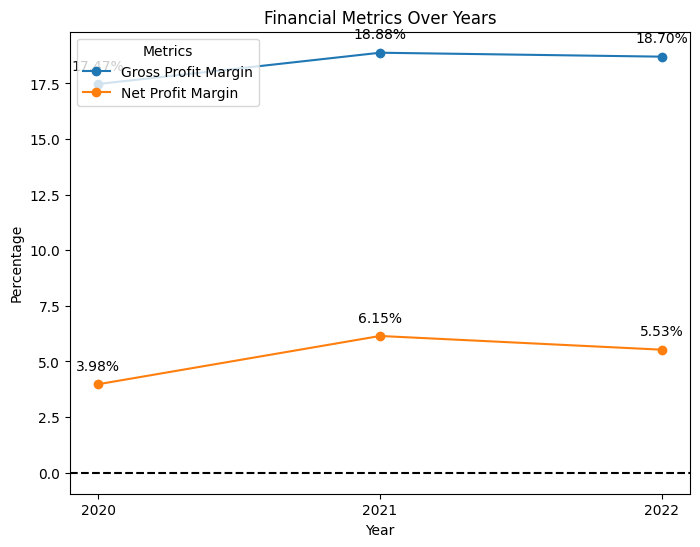

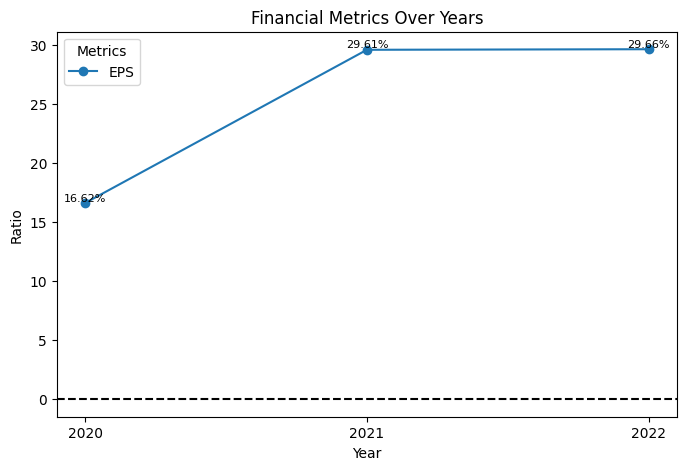

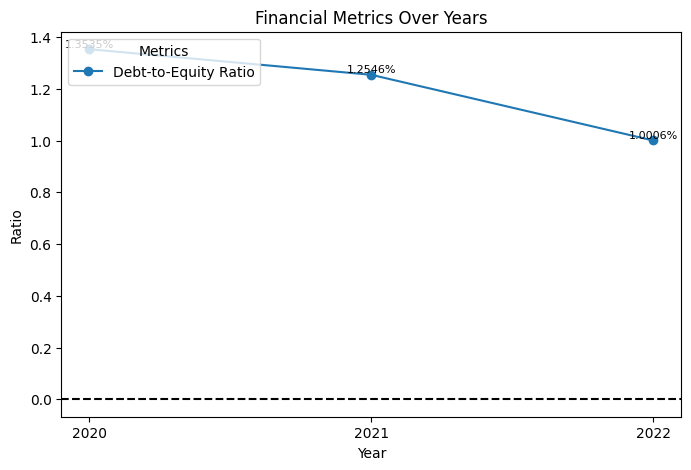

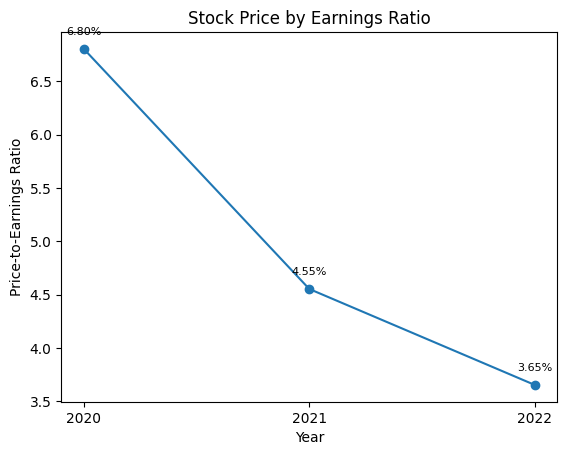

In [145]:
metrics_to_plot = ['Gross Profit Margin', 'Net Profit Margin']
df_selected_metrics = financial_metrics.loc[metrics_to_plot]
df_selected_metrics_transposed = df_selected_metrics.T

# Plotting
ax = df_selected_metrics_transposed.plot(kind='line', marker='o', figsize=(8, 6))
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Financial Metrics Over Years')
plt.legend(title='Metrics', loc='upper left')
plt.axhline(y=0, ls="--", color="black")
plt.grid(False)
plt.xticks(df_selected_metrics_transposed.index) 
for metric in metrics_to_plot:
    for i, value in enumerate(df_selected_metrics_transposed[metric]):
        ax.annotate(f'{value:.2f}%', (df_selected_metrics_transposed.index[i], value),
                    textcoords="offset points", xytext=(0,10), ha='center')

plt.show()
metrics_to_plot = ['EPS']
df_selected_metrics = financial_metrics.loc[metrics_to_plot]


df_selected_metrics_transposed = df_selected_metrics.T

# Plotting
ax = df_selected_metrics_transposed.plot(kind='line', marker='o', figsize=(8, 5))
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Financial Metrics Over Years')
plt.legend(title='Metrics', loc='upper left')
plt.axhline(y=0, ls="--", color="black")
plt.grid(False)
plt.xticks(df_selected_metrics_transposed.index)  

for metric in metrics_to_plot:
    for i, value in enumerate(df_selected_metrics_transposed[metric]):
        ax.text(df_selected_metrics_transposed.index[i], value, f'{value:.2f}%',
                ha='center', va='bottom', fontsize=8)

plt.show()
metrics_to_plot = ['Debt-to-Equity Ratio']
df_selected_metrics = financial_metrics.loc[metrics_to_plot]

df_selected_metrics_transposed = df_selected_metrics.T

# Plotting
ax = df_selected_metrics_transposed.plot(kind='line', marker='o', figsize=(8, 5))
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Financial Metrics Over Years')
plt.legend(title='Metrics', loc='upper left')
plt.axhline(y=0, ls="--", color="black")
plt.grid(False)
plt.xticks(df_selected_metrics_transposed.index)  
for metric in metrics_to_plot:
    for i, value in enumerate(df_selected_metrics_transposed[metric]):
        ax.text(df_selected_metrics_transposed.index[i], value, f'{value:.4f}%',
                ha='center', va='bottom', fontsize=8)

plt.show()
plt.plot(P_by_ERatio.index, P_by_ERatio, marker='o', linestyle='-', )


plt.title('Stock Price by Earnings Ratio')
plt.xlabel('Year')
plt.ylabel('Price-to-Earnings Ratio')
plt.grid(False)
plt.xticks(P_by_ERatio.index) 
for i, value in enumerate(P_by_ERatio):
    plt.annotate(f'{value:.2f}%', (P_by_ERatio.index[i], value),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
plt.show()

<h3>Loading Related to Technical Metrics/Indicators (Plotting)

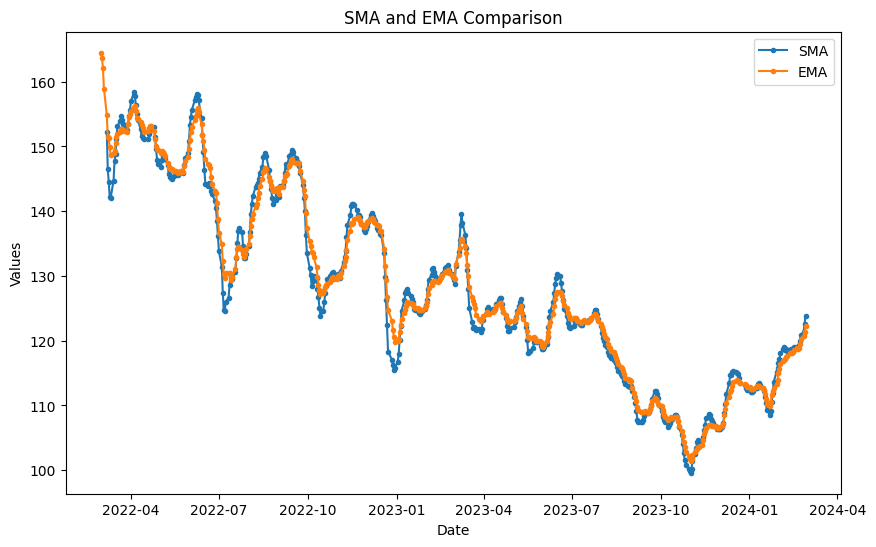

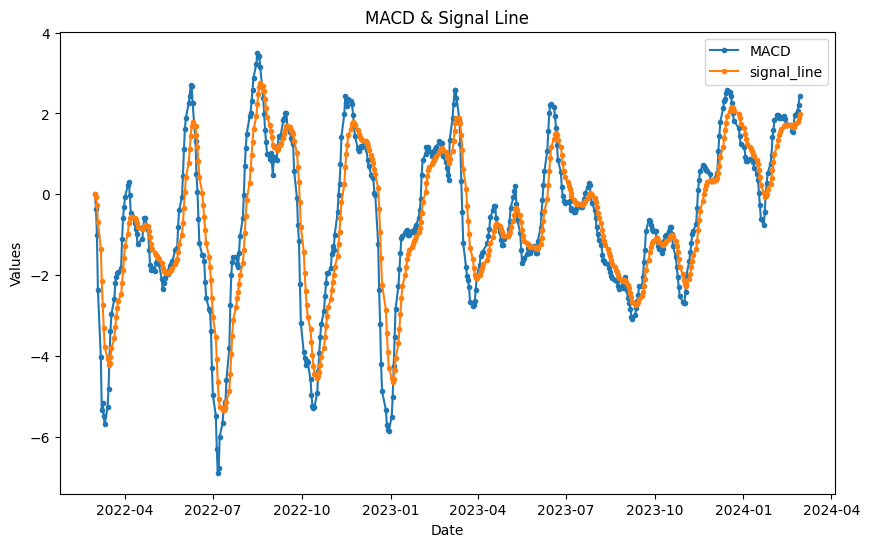

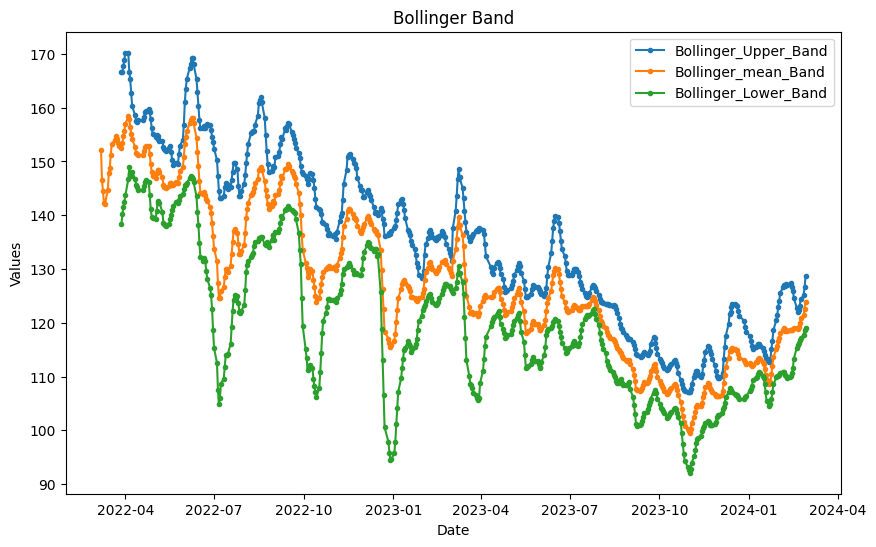

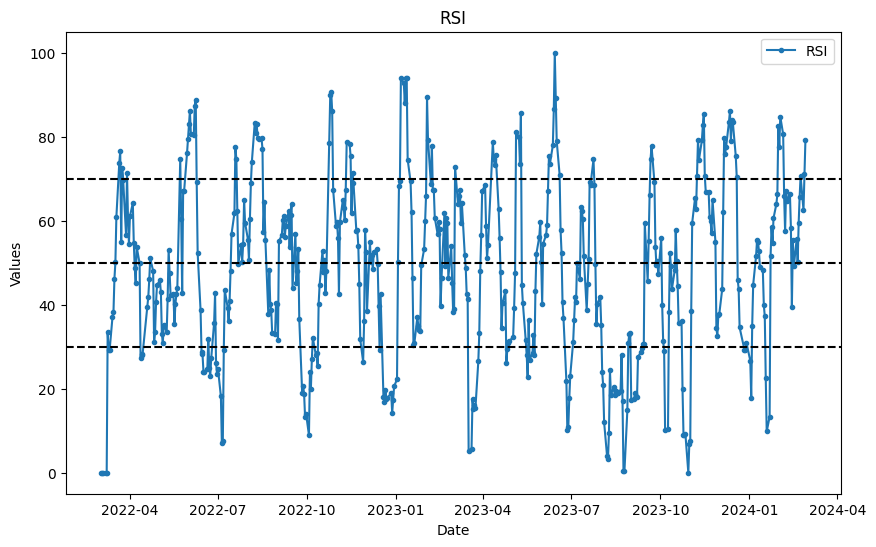

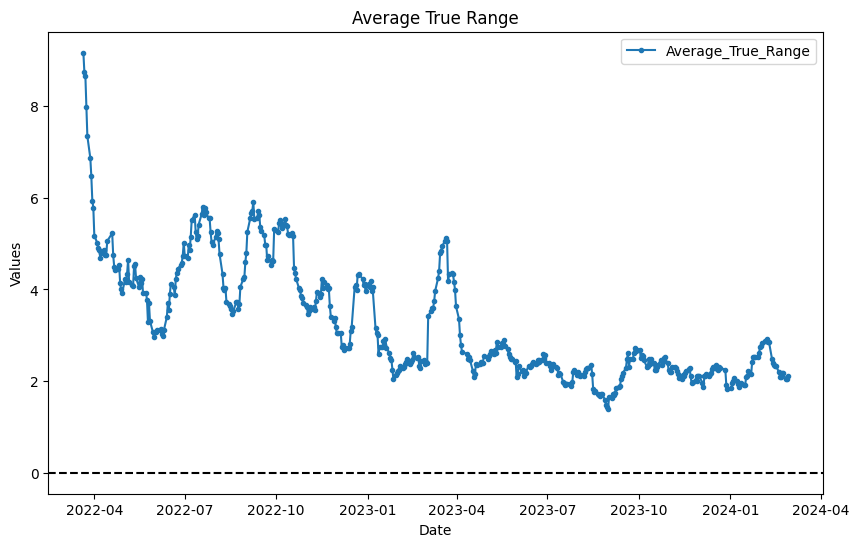

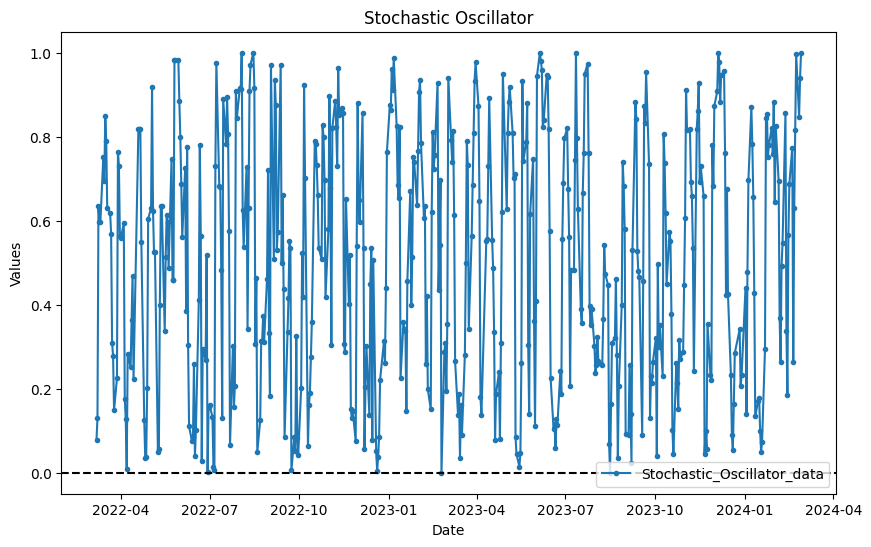

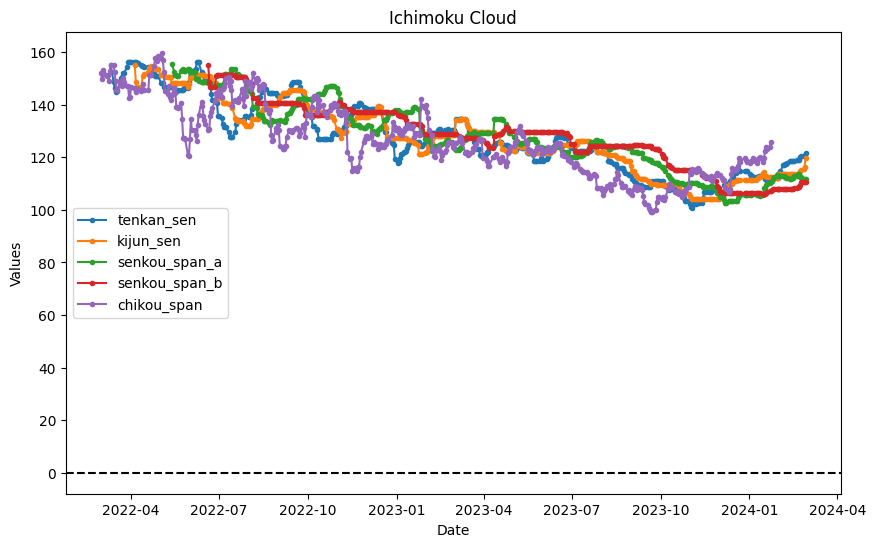

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Technical_indicator_df.index, Technical_indicator_df['SMA'], label='SMA', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['EMA'], label='EMA', marker='.', linestyle='-')

ax.set_title('SMA and EMA Comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Technical_indicator_df.index, Technical_indicator_df['MACD'], label='MACD', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['signal_line'], label='signal_line', marker='.', linestyle='-')

ax.set_title('MACD & Signal Line')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(Technical_indicator_df.index, Technical_indicator_df['Bollinger_Upper_Band'], label='Bollinger_Upper_Band', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['SMA'], label='Bollinger_mean_Band', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['Bollinger_Lower_Band'], label='Bollinger_Lower_Band', marker='.', linestyle='-')

ax.set_title('Bollinger Band')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(Technical_indicator_df.index, Technical_indicator_df['RSI'], label='RSI', marker='.', linestyle='-')

ax.set_title('RSI')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend(title='Metrics', loc='upper right')
plt.axhline(y=50, ls="--", color="black")
plt.axhline(y=70, ls="--", color="black")
plt.axhline(y=30, ls="--", color="black")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Technical_indicator_df.index, Technical_indicator_df['Average_True_Range'], label='Average_True_Range', marker='.', linestyle='-')
ax.set_title('Average True Range')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend(title='Metrics', loc='upper right')
plt.axhline(y=0, ls="--", color="black")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Technical_indicator_df.index, Technical_indicator_df['Stochastic_Oscillator_data_df'], label='Stochastic_Oscillator_data', marker='.', linestyle='-')
ax.set_title('Stochastic Oscillator')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend(title='Metrics', loc='upper right')
plt.axhline(y=0, ls="--", color="black")
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Technical_indicator_df.index, Technical_indicator_df['tenkan_sen'], label='tenkan_sen', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['kijun_sen'], label='kijun_sen', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['senkou_span_a'], label='senkou_span_a', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['senkou_span_b'], label='senkou_span_b', marker='.', linestyle='-')
ax.plot(Technical_indicator_df.index, Technical_indicator_df['chikou_span'], label='chikou_span', marker='.', linestyle='-')
ax.set_title('Ichimoku Cloud')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend(title='Metrics', loc='upper right')
plt.axhline(y=0, ls="--", color="black")
ax.legend()
plt.show()

<h3> Loading Related to Machine Learning (Timeseries Auto Arima Model)

<h4> *Identifing the best fitted model model*
<h4>the model should statisfy all three conditions mentioned below to be identified as the best model.<br>
• It should have low Akaike information criterion (AIC) Score.<br>
• For the Ljung box test p value should be higher than 0.05.<br>
• For the Jarque-Bera test p value should be lower than 0.05.<br>

In [147]:
col1 = 'Close'
close = pm.auto_arima(np.log(1+Timeseries_df[col1]), start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       n_jobs=-1,  
                       error_action='ignore',  # don't want to know if an order does not work
                       suppress_warnings=True,  # don't want convergence warnings
                       stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                       n_fits=25)


Best model:  ARIMA(1,1,2)(2,1,0)[12]          
Total fit time: 40.391 seconds


<h5>Model diagnostics and summary

In [148]:
close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  513
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 12)   Log Likelihood                1197.997
Date:                             Thu, 29 Feb 2024   AIC                          -2383.994
Time:                                     21:58:36   BIC                          -2358.706
Sample:                                          0   HQIC                         -2374.071
                                             - 513                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6964      0.196     -3.557      0.000      -1.080      -0.313
ma.L1          0.7555      0.201      3.751      0.000       0.361       1.150
ma.L2         -0.0317      0.057     -0.554      0.580      -0.144       0.080
ar.S.L12      -0.6661      0.035    -18.866      0.000      -0.735      -0.597
ar.S.L24      -0.3172      0.036     -8.862      0.000      -0.387      -0.247
sigma2         0.0005   2.15e-05     22.342      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               115.27
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The model fitness criterion

Model Fitness test:

 - 1. Ljung Box test statistic = 0.01,
     
 - 2. p-value for Ljung box test = 0.97, which is greater than 0.05,
     
 -   hence we conclude that there is no serial autocorrelations in data
     
 -  3. Jarque-Bera (JB) test statistic = 161.23
     
 -  4. p-value associated with Jarque-Bera test is <0.05, hence we say error were normally distributed
     
 - from above model fitness test, we can see that the overall model is good fit

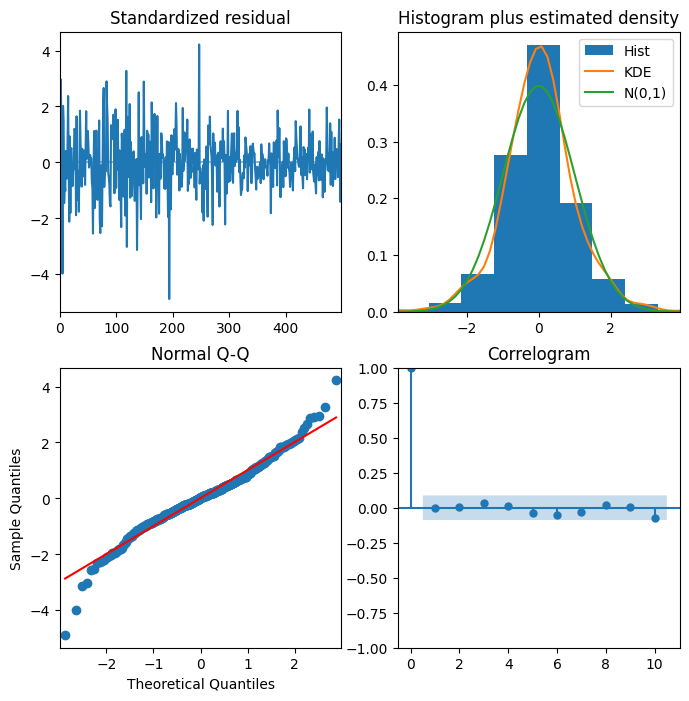

In [149]:
close.plot_diagnostics(figsize=(8,8))
plt.show()

<h4>Number of days to forecast

In [150]:
days = 7

<h4> Forecast Close stock price, give number of days to forecast

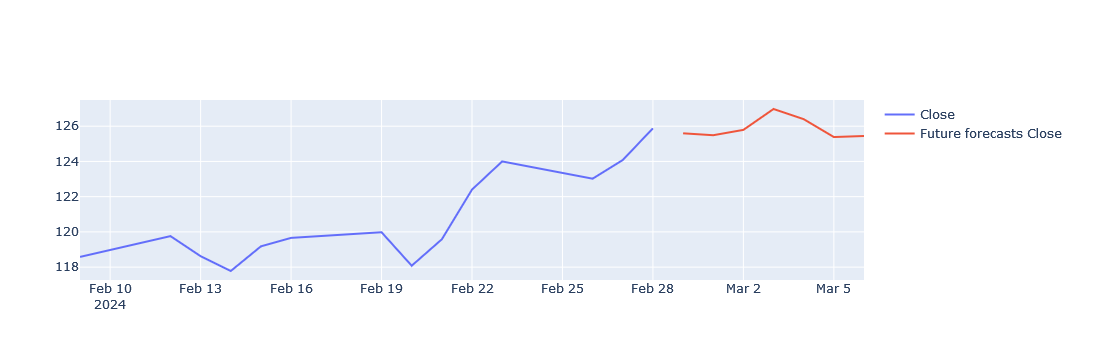

In [151]:
s = Timeseries_df[col1].tail(1).index[0]
prediction_start_date = s + dt.timedelta(days=1)  
future_dates = pd.date_range(start=prediction_start_date, periods=days)

# Use the ARIMA model to make predictions for the future dates
pred = close.predict(n_periods=days)
pred = np.exp(pred) - 1 
future_df = pd.DataFrame(pred, columns=['future Predictions'])
future_df.index = future_dates
fig = go.Figure()
fig.add_trace(go.Scatter(y=Timeseries_df[col1].tail(14), x=Timeseries_df[col1].tail(14).index,
                         mode='lines',
                         name=col1))
fig.add_trace(go.Scatter(y=future_df['future Predictions'], x=future_df.index,
                         mode='lines', name='Future forecasts ' + str(col1)))

# Show the plot
fig.show()

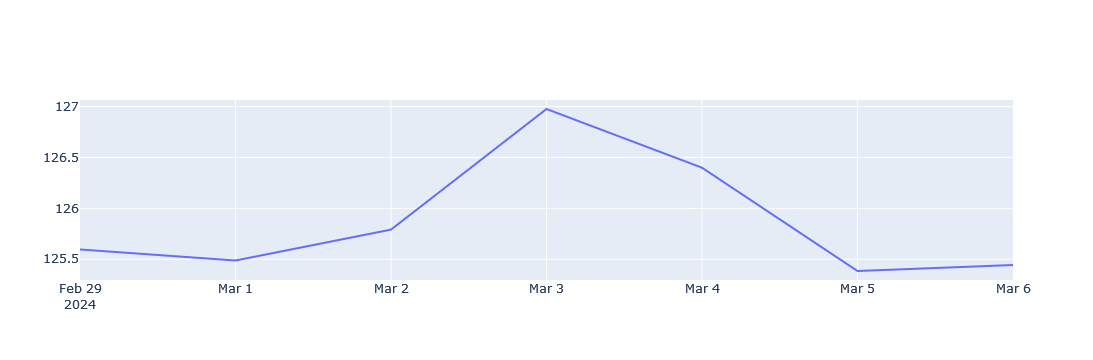

In [152]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=future_df['future Predictions'],x = future_df['future Predictions'].index,
                    mode='lines',name='Future forecasts '+ str(col1) ))
fig.show()

In [153]:
future_df

,future Predictions
2024-02-29,125.595887
2024-03-01,125.487432
2024-03-02,125.790928
2024-03-03,126.975948
2024-03-04,126.399238
2024-03-05,125.384244
2024-03-06,125.443065


## Testing Phase 2

Providing historical data

In [154]:
end_date = pd.to_datetime("2024-01-18")
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * b)
Testing_df = yf.download(tickers=a, start=start_date, end=end_date)        
Testing_df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-11,113.980003,115.720001,113.040001,113.239998,113.239998,870883
2024-01-12,113.300003,113.519997,111.400002,111.980003,111.980003,927653
2024-01-15,112.180000,112.400002,110.599998,111.480003,111.480003,551095
2024-01-16,111.160004,111.540001,110.320000,111.279999,111.279999,565207
2024-01-17,109.940002,110.019997,107.900002,108.680000,108.680000,1288695


In [155]:
col1 = 'Close'

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
close = pm.auto_arima(np.log(1 + Testing_df[col1]), start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                      start_P=0, seasonal=True, d=1, D=1, trace=True,
                      n_jobs=-1,  
                      error_action='ignore',  # Ignore errors
                      suppress_warnings=True,  # Suppress warnings
                      stepwise=False, random=True, random_state=42,  # Random search
                      n_fits=25)


Best model:  ARIMA(1,1,2)(2,1,0)[12]          
Total fit time: 24.288 seconds


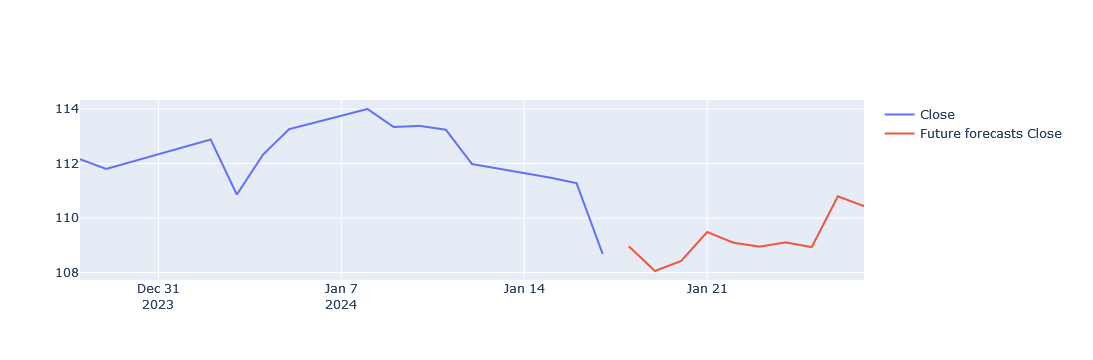

In [156]:
# Set the desired number of days for prediction
days = 10

s = Testing_df[col1].tail(1).index[0]
prediction_start_date = s + dt.timedelta(days=1)  
future_dates = pd.date_range(start=prediction_start_date, periods=days)

# Use the ARIMA model to make predictions for the future dates
pred = close.predict(n_periods=days)
pred = np.exp(pred) - 1 
T_future_df = pd.DataFrame(pred, columns=['future Predictions'])
T_future_df.index = future_dates
fig = go.Figure()
fig.add_trace(go.Scatter(y=Testing_df[col1].tail(14), x=Testing_df[col1].tail(14).index,
                         mode='lines',
                         name=col1))
fig.add_trace(go.Scatter(y=T_future_df['future Predictions'], x=T_future_df.index,
                         mode='lines', name='Future forecasts ' + str(col1)))

fig.show()

In [157]:
T_future_df

,future Predictions
2024-01-18,108.965761
2024-01-19,108.056104
2024-01-20,108.422786
2024-01-21,109.486728
2024-01-22,109.094815
2024-01-23,108.949679
2024-01-24,109.105801
2024-01-25,108.933392
2024-01-26,110.794582
2024-01-27,110.435793


In [158]:
end_date = pd.to_datetime("2024-01-31")
start_date = pd.to_datetime(end_date)-pd.DateOffset(30)
Testing2_df = yf.download(tickers = a, 
                      start = start_date, 
                      end = end_date)
        
Testing2_df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-24,115.680000,117.620003,114.860001,116.000000,116.000000,1357985
2024-01-25,115.639999,115.820000,113.540001,114.839996,114.839996,1232015
2024-01-26,114.900002,115.720001,113.639999,115.339996,115.339996,873874
2024-01-29,115.000000,115.959999,114.220001,115.959999,115.959999,578550
2024-01-30,116.379997,117.419998,114.760002,116.639999,116.639999,1180093


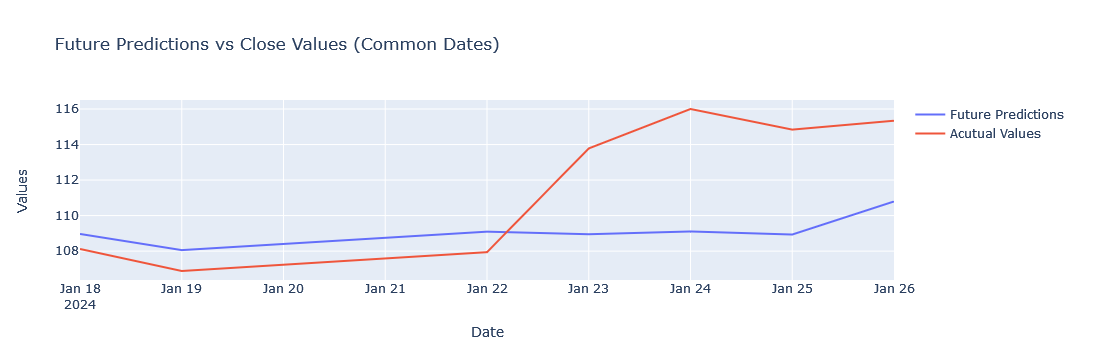

In [159]:
common_dates = T_future_df.index.intersection(Testing2_df.index)

# Filter DataFrames based on common dates
T_common_df = T_future_df.loc[common_dates]
Testing2_common_df = Testing2_df.loc[common_dates]
trace1 = go.Scatter(x=T_common_df.index, y=T_common_df['future Predictions'], mode='lines', name='Future Predictions')
trace2 = go.Scatter(x=Testing2_common_df.index, y=Testing2_common_df['Close'], mode='lines', name='Acutual Values')
layout = go.Layout(title='Future Predictions vs Close Values (Common Dates)',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Values'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()
